# Pymaceuticals Inc.
---

### Analysis

- Add your analysis here.
 

In [1]:
# Dependencies and Setup
#added Path and numpy to what was given
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress


# Study data files
mouse_metadata_path = Path("data/Mouse_metadata.csv")
study_results_path = Path("data/Study_results.csv")

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single DataFrame
#merge on Mouse ID.
merged_df=pd.merge(study_results,mouse_metadata, on='Mouse ID',how='left')
# Display the data table for preview
merged_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [2]:
# Checking the number of mice.
#put the unique mouse IDS into a list and count the list.
#could also .count Mouse ID from the Mouse_metadata, but in the interest of working in the merged dataframe I opted this method. 
mice_count= len(merged_df['Mouse ID'].unique())
mice_count

249

In [3]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint.
#I actually output the next step correctly before adding the final two lines here. Makes me think I did this a way not intended. #UPDATE ameneded second line so it ordered as intended 
#my understanding is .duplicated will mark everything as T or F, F meaning no duplicate in the dataset columns specified by subset.
#keep = False was the part i had to look up. But as I understand it will mark duplicates as True.
#.unique of the new list prints the singular duplicate,  
duplicate_mice = merged_df[merged_df.duplicated(subset=['Mouse ID', 'Timepoint'], keep=False)]
duplicate_mice_ids = duplicate_mice['Mouse ID'].unique()
duplicate_mice_ids



array(['g989'], dtype=object)

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
#Brian L in class gave me this line, I wasnt using loc before and seems to be that was the issue.  I was getting 10/13 rows by the method i came up with and the drop did not work. 
duplicate_mice_data = merged_df.loc[merged_df['Mouse ID'] == 'g989', :]
duplicate_mice_data

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
#just take the inverse from the line above, being we have one duplicate, this is possible.
cleaned_df = merged_df.loc[merged_df['Mouse ID'] != 'g989', :]
cleaned_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [6]:
# Checking the number of mice in the clean DataFrame.
#count rows now that dupe is dropped
len(cleaned_df['Mouse ID'].unique())


248

## Summary Statistics

In [7]:

#it made much more sense to me to change the order of this. makes the dataframe code easier to parse as well. 
#create grouped list then peel summary statistics off that and store in variables. 
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
grouped_drugs=cleaned_df.groupby('Drug Regimen')
tumor_mean=grouped_drugs['Tumor Volume (mm3)'].mean()
tumor_median=grouped_drugs['Tumor Volume (mm3)'].median()
tumor_var=grouped_drugs['Tumor Volume (mm3)'].var()
tumor_std=grouped_drugs['Tumor Volume (mm3)'].std()
tumor_sem=grouped_drugs['Tumor Volume (mm3)'].sem()
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
tumor_table=pd.DataFrame({'Mean Tumor Volume':tumor_mean,
                        'Median Tumor Volume':tumor_median,
                        'Tumor Volume Variance':tumor_var,
                        'Tumor Volume Std. Dev':tumor_std,
                        'Tumor Volume Std. Err.':tumor_sem})

tumor_table

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [ ]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line


## Bar and Pie Charts

Text(0, 0.5, '# of Observed Mouse Timepoints')

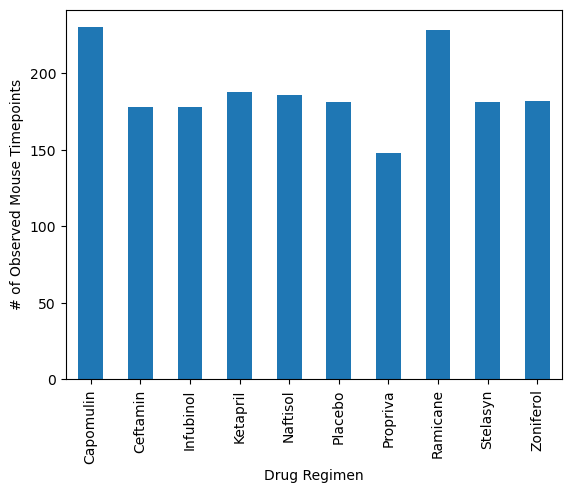

In [8]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
per_regimen_counts=grouped_drugs.size()
per_regimen_counts.plot(kind='bar',layout='tight',align='center' )
plt.xlabel('Drug Regimen')
plt.ylabel('# of Observed Mouse Timepoints')


Text(0, 0.5, '# of Observed Mouse Timepoints')

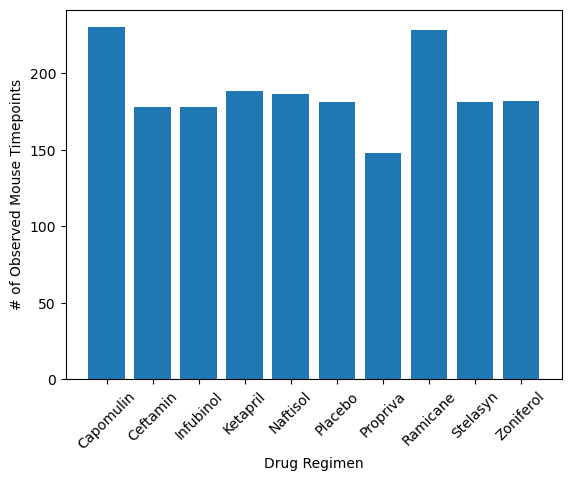

In [9]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
#was able to do this in short order besides getting the x axis label to display the name instead of the index position. the x_axis line above was added to address.
#then it still wasnt readable so I added rotation to the labels.
x_axis=per_regimen_counts.index.tolist()
count=per_regimen_counts.tolist()
plt.bar(x_axis,count,align='center')
plt.xlabel('Drug Regimen')
plt.xticks(rotation=45)
plt.ylabel('# of Observed Mouse Timepoints')

Text(0, 0.5, '')

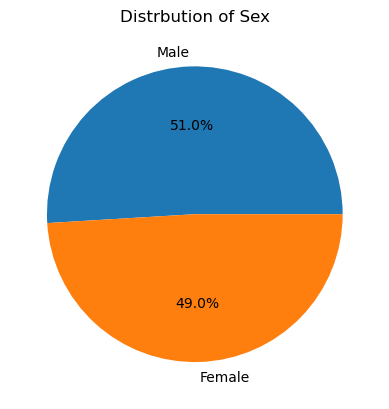

In [10]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
#create variable to count the mice that are male and female
#plug that variable into plot creation
#Was getting "count" as ylabel so i set to blank manually
sex_count=cleaned_df['Sex'].value_counts()
sex_count.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distrbution of Sex')
plt.ylabel('')





Text(0.5, 1.0, 'Sex Distribution')

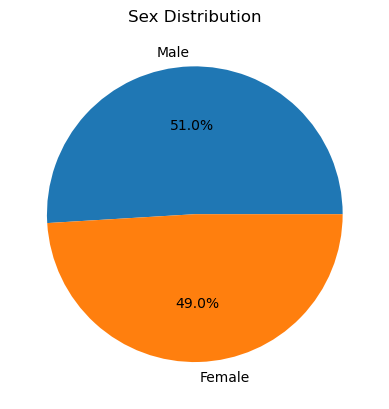

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
#use a loop to get counts for each
#quick pivot off the loop, once i made sex_count variable everything else flowed. Referenced classwork to get % displayed on chart
labels=['Male', 'Female']
plt.pie(sex_count,labels=labels,autopct="%1.1f%%")
plt.title('Sex Distribution')


## Quartiles, Outliers and Boxplots

In [12]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
#create list of choice regimens to compare to
#filter cleanedDF by choice regimens to get rid of extra data entries
#grouby and filter then call.last 






# Start by getting the last (greatest) timepoint for each mouse
final_tumor_time=cleaned_df.groupby('Mouse ID')['Timepoint'].max()
max_timepoint_df = pd.DataFrame(final_tumor_time)


# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
max_time_table=pd.merge(max_timepoint_df,cleaned_df,on=['Mouse ID','Timepoint'])
max_time_table


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,a203,45,67.973419,2,Infubinol,Female,20,23
1,a251,45,65.525743,1,Infubinol,Female,21,25
2,a262,45,70.717621,4,Placebo,Female,17,29
3,a275,45,62.999356,3,Ceftamin,Female,20,28
4,a366,30,63.440686,1,Stelasyn,Female,16,29
...,...,...,...,...,...,...,...,...
243,z435,10,48.710661,0,Propriva,Female,12,26
244,z578,45,30.638696,0,Ramicane,Male,11,16
245,z581,45,62.754451,3,Infubinol,Female,24,25
246,z795,45,65.741070,3,Naftisol,Female,13,29


In [13]:
# Put treatments into a list for for loop (and later for plot labels)

choice_regimens=['Capomulin','Ramicane','Infubinol','Ceftamin']
choice_filtered_df=max_time_table[max_time_table['Drug Regimen'].isin(choice_regimens)]

# Create empty list to fill with tumor vol data (for plotting)

tumor_vol_data=[]


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

#Jon helped me with this part, i had a solid attempt on my own, but he really helped clean it up.
#my hangup was the foorloop seeming "disconnected", for some reason I thought you had to perform operation in the list you iterated through.  

    # Locate the rows which contain mice on each drug and get the tumor volumes
for drug in choice_regimens:
    tumor_list=choice_filtered_df.loc[choice_filtered_df['Drug Regimen']==drug,'Tumor Volume (mm3)']
    tumor_vol_data.append(tumor_list)
    quartiles=tumor_list.quantile([.25,.5,.75])
    lowerq=quartiles[0.25]
    upperq=quartiles[0.75]
    iqr=upperq-lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)

    
    # Determine outliers using upper and lower bounds
    outliers = tumor_list.loc[(tumor_list < lower_bound) |(tumor_list > upper_bound)]
    print(drug,outliers)

Capomulin Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin Series([], Name: Tumor Volume (mm3), dtype: float64)


In [37]:
print(choice_filtered_df)

    Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites Drug Regimen  \
0       a203         45           67.973419                 2    Infubinol   
1       a251         45           65.525743                 1    Infubinol   
3       a275         45           62.999356                 3     Ceftamin   
6       a411         45           38.407618                 1     Ramicane   
7       a444         45           43.047543                 0     Ramicane   
..       ...        ...                 ...               ...          ...   
238     y769         45           68.594745                 4     Ceftamin   
239     y793         45           31.896238                 2    Capomulin   
240     y865         45           64.729837                 3     Ceftamin   
244     z578         45           30.638696                 0     Ramicane   
245     z581         45           62.754451                 3    Infubinol   

        Sex  Age_months  Weight (g)  
0    Female          20  

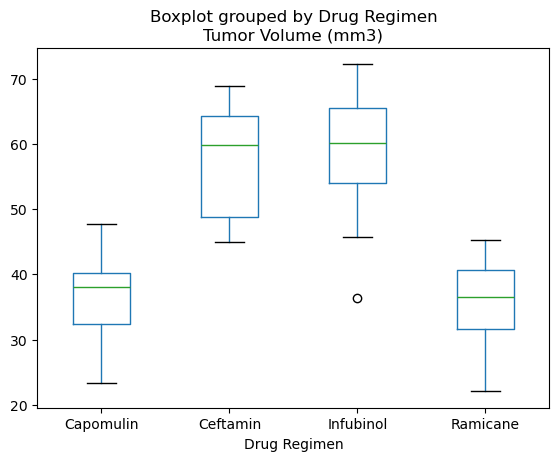

In [14]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
boxplot = choice_filtered_df.boxplot(column='Tumor Volume (mm3)', by='Drug Regimen',grid=False,)


## Line and Scatter Plots

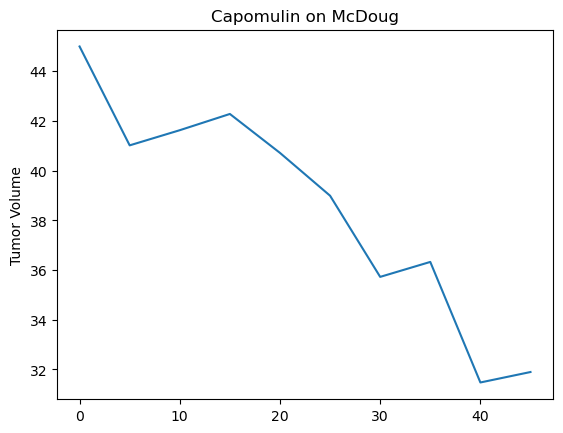

In [98]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
#not sure if hardcoding the mouse is ok, but it works for now I guess.
#finally getting a firm grasp on loc
mcdoug_time=cleaned_df.loc[cleaned_df['Mouse ID']=='y793','Timepoint']
mcdoug_volume=cleaned_df.loc[cleaned_df['Mouse ID']=='y793','Tumor Volume (mm3)']

plt.title("Capomulin on McDoug")
plt.ylabel("Tumor Volume")
plt.plot(mcdoug_time,mcdoug_volume)

<Axes: xlabel='Weight (g)', ylabel='Tumor Volume (mm3)'>

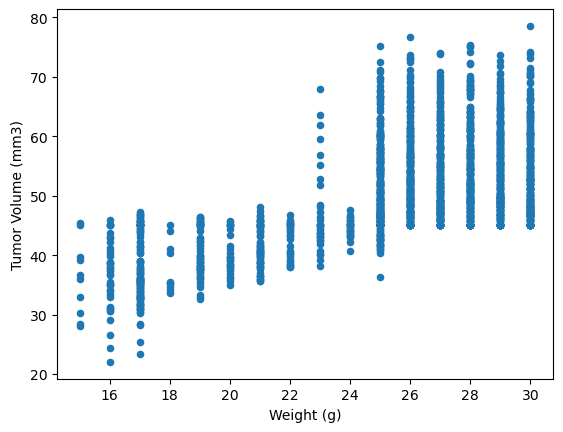

In [113]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen

cleaned_df.plot(kind='scatter',x='Weight (g)',y='Tumor Volume (mm3)')

## Correlation and Regression

In [19]:
# Calculate the correlation coefficient and a linear regression model 
# for mouse weight and average observed tumor volume for the entire Capomulin regimen
average_tumor_volume = cleaned_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].mean()
average_mouse_weight=cleaned_df.groupby('Drug Regimen')['Weight (g)'].mean()
regressionanal=(slope, intercept, rvalue, pvalue, stderr) = linregress(average_tumor_volume, average_mouse_weight)
regressionanal


LinregressResult(slope=0.5761202712920723, intercept=-3.380207721692809, rvalue=0.992143972148151, pvalue=1.6507830960191824e-08, stderr=0.025683566612126535, intercept_stderr=1.316389844603078)

In [ ]:
#i honestly am not that pleased to submit this as I know it could be better. But I was sick last week and had trouble following in class, so I had to rewatch all the class videos and basicaclly this just tookso much time that im too 
#fried to perfect this. 